In [3]:
import time
import functools
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tqdm import trange
import librosa
import catboost
import torchvision
from models.resnet import ResNet18
from utils.dataset import LIBRITTS
from typing import Tuple
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Обучение конструктора признаков на базе ResNet18

In [2]:
# Параметры
BATCH_SIZE = 32
USE_AMP = True
EPOCHS = 10 #250
LR = 0.1
WEIGHT_DECAY = 5e-4
SAMPLE_RATE = 24000
N_MELS = 128
N_FFT = 1024

In [3]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.manual_seed(24)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
print("Using {} device".format(device))

Using cuda device


Загружаем датасет

In [6]:
sample_transforms_test = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                        n_fft=N_FFT, 
                                        n_mels=N_MELS,
                                        normalized=True),
    torchvision.transforms.Resize((128, 128))
])

sample_transforms_train = torchvision.transforms.Compose([
    torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE,
                                        n_fft=N_FFT, 
                                        n_mels=N_MELS,
                                        normalized=True),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=40),
    torchaudio.transforms.TimeMasking(time_mask_param=40),
    torchvision.transforms.Resize((128, 128))
])

In [7]:
gender_labels = torch.load('./data/labels/gender_labels')

In [8]:
test_dataset = LIBRITTS(
    root='./data/',
    url="test-clean",
    download=True,
    gender_labels=gender_labels,
    transforms=sample_transforms_test
)

In [9]:
train_dataset = LIBRITTS(
    root='./data/',
    url="train-clean-100",
    download=True,
    gender_labels=gender_labels,
    transforms=sample_transforms_train
)

In [10]:
len_train_dataset = len(train_dataset)
part_train = int(len_train_dataset*0.8)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [part_train, len_train_dataset - part_train])

### Посмотрим на датасет     
В датасете не имеется информация о поле спикера, но мы можем достать ее из файла ```speakers.tsv```    
С помощью функции utils.get_labels получаем словарь вида {speaker_id: gender[0,1]}    
В первую очередь нас интересует его сбалансированность. Тренировочная выборка является сбалансированной, что не можен не радовать.

In [16]:
def count_labels(dataset, name: str):
    count_M = 0
    count_F = 0
    for sample in dataset:
        gender = sample[1]
        if gender == 1:
            count_M += 1
        elif gender == 0:
            count_F += 1
    assert len(dataset) == count_F + count_M, "Размер датасета и количество учтенных семплов не совпадает"
    print(f"В датасете {name}: {count_M} мужских и {count_F} женских семплов")

In [17]:
count_labels(train_dataset, 'train')
count_labels(val_dataset, 'val')
count_labels(test_dataset, 'test')

В датасете train: 12479 мужских и 14109 женских семплов
В датасете val: 3128 мужских и 3520 женских семплов
В датасете test: 1907 мужских и 2930 женских семплов


In [11]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers = 2,
                                          pin_memory = True)

val_data_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers = 2,
                                          pin_memory = True)
                                        
test_data_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=False,
                                          num_workers = 2,
                                          pin_memory = True)

In [12]:
# Проверим что загрузчики работают
for data, label in train_data_loader:
    print(f' Data shape: {data.shape}, label shape: {label.shape}')
    break

 Data shape: torch.Size([32, 1, 128, 128]), label shape: torch.Size([32])


Признаки будем извлекать с помощью ResNet18

In [14]:
def count_correct(y_pred: Tensor, y_true: Tensor) -> float:
    """Считает количество истинно-положительных предсказаний.

    Args:
        y_pred (Tensor):
        y_true (Tensor):

    Returns:
        float: 
    """
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    result_sum = (y_pred_tag == y_true).sum().item()
    return result_sum

In [27]:
model = ResNet18().to(device)

In [28]:
loss_fn = torch.nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 200)

In [29]:
# Training logs
interval = 100
train_ts, train_loss, train_acc = [], [], []
val_ts, val_loss, val_acc = [], [], []

In [30]:
def show_progress(t: float):
    """Выводит графики. 

    Args:
        t (float): момент обучения (эпоха), может быть дробным
    """
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3)
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5)
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(train_ts, train_acc, c='darkblue', lw=3)
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5)
    plt.show() 

In [31]:
def train(epoch: int, dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module, optimizer: Optimizer):
    """Функция обучения.

    Args:
        epoch (int): текущая эпоха
        dataloader (DataLoader): загрузчик данных
        model (nn.Module): обучаемая модель
        loss_fn (nn.Module): функция потерь
        optimizer (Optimizer): оптимизатор
    """
    model.train()
    num_batches = len(dataloader)
    correct, size = 0, 0
    train_error = 0
    for batch, (X, y) in enumerate(dataloader):
        # Send data to training device
        X, y = X.to(device), y.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y.unsqueeze(1))
        # Backpropagation
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # Здесь не будет обрезания градиентов 
        train_error += loss.item()
        # Посчитаем accuracy
        correct += count_correct(pred, y.unsqueeze(1))
        size += len(X)
        # Сбросим градиенты альтернативным способом
        for param in model.parameters():
            param.grad = None
        # Progress output
    train_ts.append(epoch+1)
    train_loss.append(train_error / num_batches)
    train_acc.append(correct / size)
    show_progress(epoch+1)

In [32]:
def test(epoch: int, dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module):
    """Функция инференса.

    Args:
        epoch (int): номер текущей эпохи
        dataloader (DataLoader): загрузчик данных
        model (nn.Module): воспроизводимая модель
        loss_fn (nn.Module): функция потерь
    """
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            correct += count_correct(pred, y.unsqueeze(1))
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

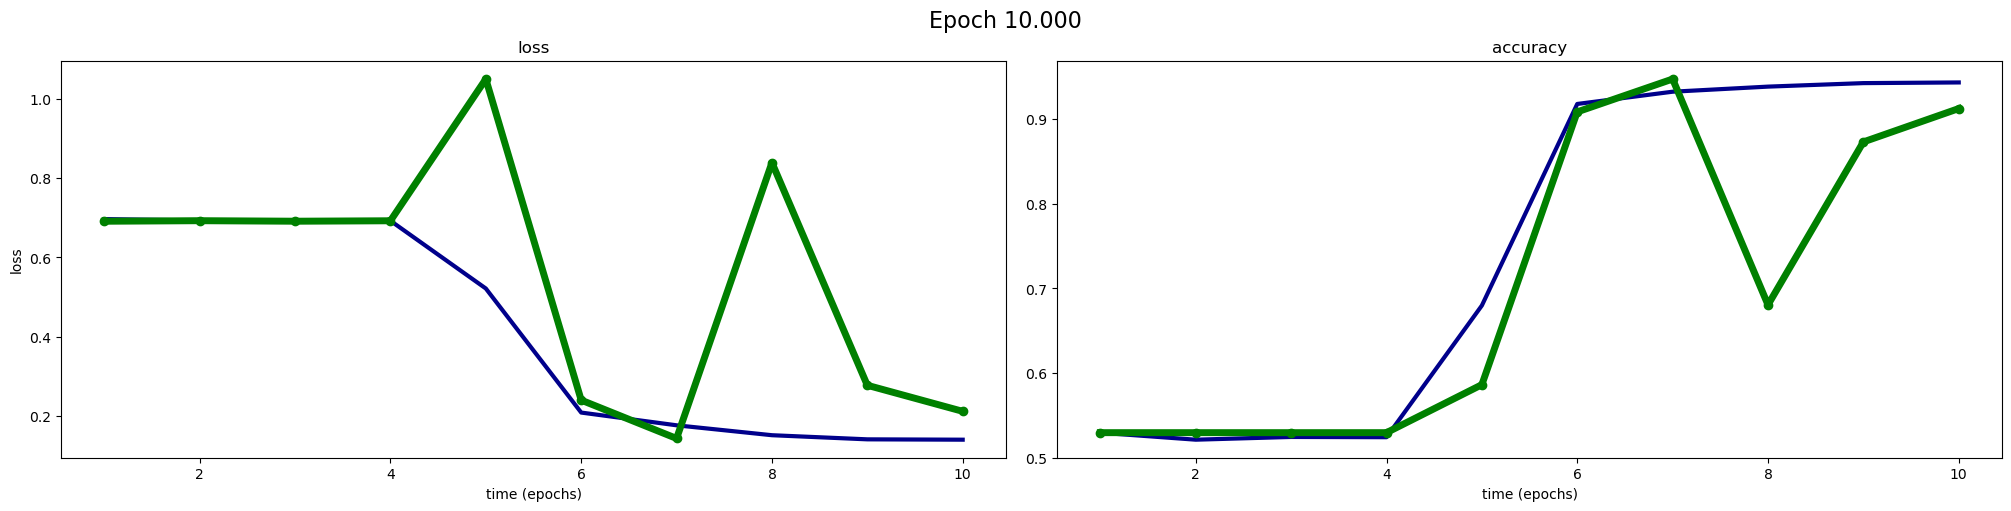

100%|██████████| 10/10 [17:30<00:00, 105.07s/it]


In [33]:
for t in trange(EPOCHS):
    train(t, train_data_loader, model, loss_fn, optimizer)
    test(t, val_data_loader, model, loss_fn)
    scheduler.step()

In [34]:
torch.save(model, './parameters/model.pkl')

In [36]:
val_acc[-1]

0.9124548736462094

In [37]:
# Посчитаем accuracy для test
def test(epoch: int, dataloader: DataLoader, model: nn.Module, loss_fn: nn.Module) -> float:
    """ "Одноразовая" функция инференсa.

    Args:
        epoch (int): номер текущей эпохи
        dataloader (DataLoader): загрузчик данных
        model (nn.Module): воспроизводимая модель
        loss_fn (nn.Module): функция потерь

    Returns:
        float: accuracy
    """
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.unsqueeze(1)).item()
            correct += count_correct(pred, y.unsqueeze(1))
    test_loss /= num_batches
    correct /= size
    return correct

Отдельно, предварительно посчитаем точность на тестовом датасете. Получили Accuracy 0.96. Это не итоговый результат. Целью данного этапа было обучения нейронной сети способной выделять ключевые признаки из аудиофайлов для бинарной классификации.

In [38]:
test(10, test_data_loader, model, loss_fn)

0.9652677279305355